# Method 7 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

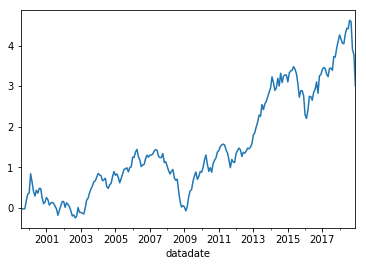

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.340355
2000-12-31   -0.147532
2001-12-31    0.012515
2002-12-31   -0.233288
2003-12-31    0.980803
2004-12-31    0.078494
2005-12-31    0.062963
2006-12-31    0.116769
2007-12-31   -0.049886
2008-12-31   -0.506129
2009-12-31    0.796629
2010-12-31    0.252904
2011-12-31   -0.107879
2012-12-31    0.217950
2013-12-31    0.492865
2014-12-31    0.109030
2015-12-31   -0.120136
2016-12-31    0.138705
2017-12-31    0.191166
2018-12-31   -0.215224
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     367.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-98
Time:                        21:26:20   Log-Likelihood:                 511.09
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.522      0.012       0.001       0.008
mktrf          0.8851      0.051     17.234      0.000       0.784       0.986
me             0.7846      0.060     13.134      0.000       0.667       0.902
ia             0.1030      0.091      1.134      0.258      -0.076       0.282
roe           -0.7986      0.078    -10.275      0.000      -0.952      -0.645
==============================================================================
Omnibus:                       38.388   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.787
Skew:                           0.680   Prob(JB):                     5.32e-25
Kurtosis:                       6.101   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     167.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.60e-67
Time:                        21:26:20   Log-Likelihood:                 511.09
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.273      0.023       0.001       0.009
mktrf          0.8851      0.052     17.047      0.000       0.783       0.987
me             0.7846      0.116      6.736      0.000       0.556       1.013
ia             0.1030      0.184      0.561      0.575      -0.257       0.463
roe           -0.7986      0.134     -5.972      0.000      -1.061      -0.536
==============================================================================
Omnibus:                       38.388   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.787
Skew:                           0.680   Prob(JB):                     5.32e-25
Kurtosis:                       6.101   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     175.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.58e-68
Time:                        21:26:20   Log-Likelihood:                 511.09
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.318      0.020       0.001       0.009
mktrf          0.8851      0.052     17.172      0.000       0.784       0.986
me             0.7846      0.128      6.150      0.000       0.535       1.035
ia             0.1030      0.150      0.688      0.491      -0.190       0.396
roe           -0.7986      0.148     -5.406      0.000      -1.088      -0.509
==============================================================================
Omnibus:                       38.388   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.787
Skew:                           0.680   Prob(JB):                     5.32e-25
Kurtosis:                       6.101   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     284.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.85e-96
Time:                        21:26:20   Log-Likelihood:                 508.26
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     228   BIC:                            -983.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.059      0.041       0.000       0.008
mktrf          0.9972      0.052     19.104      0.000       0.894       1.100
smb            0.7671      0.069     11.139      0.000       0.631       0.903
hml           -0.0743      0.081     -0.915      0.361      -0.234       0.086
rmw           -0.7306      0.092     -7.957      0.000      -0.912      -0.550
cma            0.3872      0.117      3.317      0.001       0.157       0.617
==============================================================================
Omnibus:                       30.229   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.592
Skew:                           0.731   Prob(JB):                     1.70e-11
Kurtosis:                       4.717   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     154.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.05e-71
Time:                        21:26:20   Log-Likelihood:                 508.26
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     228   BIC:                            -983.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.870      0.061      -0.000       0.008
mktrf          0.9972      0.053     18.693      0.000       0.893       1.102
smb            0.7671      0.078      9.776      0.000       0.613       0.921
hml           -0.0743      0.130     -0.572      0.567      -0.329       0.180
rmw           -0.7306      0.142     -5.140      0.000      -1.009      -0.452
cma            0.3872      0.180      2.148      0.032       0.034       0.741
==============================================================================
Omnibus:                       30.229   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.592
Skew:                           0.731   Prob(JB):                     1.70e-11
Kurtosis:                       4.717   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     171.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.13e-75
Time:                        21:26:20   Log-Likelihood:                 508.26
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     228   BIC:                            -983.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.881      0.060      -0.000       0.008
mktrf          0.9972      0.058     17.057      0.000       0.883       1.112
smb            0.7671      0.084      9.133      0.000       0.603       0.932
hml           -0.0743      0.120     -0.619      0.536      -0.310       0.161
rmw           -0.7306      0.156     -4.685      0.000      -1.036      -0.425
cma            0.3872      0.143      2.703      0.007       0.106       0.668
==============================================================================
Omnibus:                       30.229   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.592
Skew:                           0.731   Prob(JB):                     1.70e-11
Kurtosis:                       4.717   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     273.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.59e-86
Time:                        21:26:20   Log-Likelihood:                 481.80
No. Observations:                 234   AIC:                            -953.6
Df Residuals:                     229   BIC:                            -936.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.933      0.352      -0.002       0.006
mktrf          1.0689      0.054     19.946      0.000       0.963       1.174
smb            1.0646      0.067     15.914      0.000       0.933       1.196
hml            0.0048      0.066      0.072      0.943      -0.126       0.136
umd           -0.1523      0.044     -3.493      0.001      -0.238      -0.066
==============================================================================
Omnibus:                       45.110   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.470
Skew:                           0.783   Prob(JB):                     1.91e-31
Kurtosis:                       6.472   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     180.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-69
Time:                        21:26:20   Log-Likelihood:                 481.80
No. Observations:                 234   AIC:                            -953.6
Df Residuals:                     229   BIC:                            -936.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.914      0.361      -0.002       0.006
mktrf          1.0689      0.045     23.767      0.000       0.981       1.157
smb            1.0646      0.108      9.869      0.000       0.853       1.276
hml            0.0048      0.133      0.036      0.971      -0.256       0.265
umd           -0.1523      0.097     -1.570      0.116      -0.342       0.038
==============================================================================
Omnibus:                       45.110   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.470
Skew:                           0.783   Prob(JB):                     1.91e-31
Kurtosis:                       6.472   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     168.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.32e-67
Time:                        21:26:20   Log-Likelihood:                 481.80
No. Observations:                 234   AIC:                            -953.6
Df Residuals:                     229   BIC:                            -936.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.976      0.329      -0.002       0.006
mktrf          1.0689      0.046     23.061      0.000       0.978       1.160
smb            1.0646      0.104     10.263      0.000       0.861       1.268
hml            0.0048      0.125      0.038      0.970      -0.240       0.250
umd           -0.1523      0.104     -1.466      0.143      -0.356       0.051
==============================================================================
Omnibus:                       45.110   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.470
Skew:                           0.783   Prob(JB):                     1.91e-31
Kurtosis:                       6.472   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     173.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-47
Time:                        21:26:20   Log-Likelihood:                 236.67
No. Observations:                 120   AIC:                            -463.3
Df Residuals:                     115   BIC:                            -449.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      1.995      0.048    4.72e-05       0.013
mktrf          0.8851      0.089      9.985      0.000       0.710       1.061
me             0.8362      0.088      9.550      0.000       0.663       1.010
ia             0.1165      0.137      0.850      0.397      -0.155       0.388
roe           -0.8071      0.121     -6.651      0.000      -1.048      -0.567
==============================================================================
Omnibus:                       10.980   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.043
Skew:                           0.482   Prob(JB):                     0.000541
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     81.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-32
Time:                        21:26:20   Log-Likelihood:                 236.67
No. Observations:                 120   AIC:                            -463.3
Df Residuals:                     115   BIC:                            -449.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.004      1.869      0.062      -0.000       0.013
mktrf          0.8851      0.093      9.568      0.000       0.704       1.066
me             0.8362      0.145      5.761      0.000       0.552       1.121
ia             0.1165      0.255      0.458      0.647      -0.383       0.616
roe           -0.8071      0.193     -4.178      0.000      -1.186      -0.429
==============================================================================
Omnibus:                       10.980   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.043
Skew:                           0.482   Prob(JB):                     0.000541
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     92.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.76e-35
Time:                        21:26:20   Log-Likelihood:                 236.67
No. Observations:                 120   AIC:                            -463.3
Df Residuals:                     115   BIC:                            -449.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      1.905      0.057      -0.000       0.013
mktrf          0.8851      0.094      9.381      0.000       0.700       1.070
me             0.8362      0.161      5.190      0.000       0.520       1.152
ia             0.1165      0.213      0.548      0.584      -0.300       0.533
roe           -0.8071      0.214     -3.773      0.000      -1.226      -0.388
==============================================================================
Omnibus:                       10.980   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.043
Skew:                           0.482   Prob(JB):                     0.000541
Kurtosis:                       4.442   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     145.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-47
Time:                        21:26:20   Log-Likelihood:                 239.44
No. Observations:                 120   AIC:                            -466.9
Df Residuals:                     114   BIC:                            -450.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.278      0.025       0.001       0.014
mktrf          1.0639      0.092     11.596      0.000       0.882       1.246
smb            0.8089      0.104      7.785      0.000       0.603       1.015
hml           -0.1163      0.127     -0.913      0.363      -0.369       0.136
rmw           -0.6999      0.150     -4.661      0.000      -0.997      -0.402
cma            0.4837      0.164      2.941      0.004       0.158       0.810
==============================================================================
Omnibus:                        5.772   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.222
Skew:                           0.474   Prob(JB):                       0.0735
Kurtosis:                       3.384   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     140.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.88e-47
Time:                        21:26:21   Log-Likelihood:                 239.44
No. Observations:                 120   AIC:                            -466.9
Df Residuals:                     114   BIC:                            -450.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.247      0.025       0.001       0.014
mktrf          1.0639      0.079     13.545      0.000       0.910       1.218
smb            0.8089      0.114      7.122      0.000       0.586       1.031
hml           -0.1163      0.214     -0.544      0.586      -0.535       0.303
rmw           -0.6999      0.219     -3.201      0.001      -1.128      -0.271
cma            0.4837      0.219      2.205      0.027       0.054       0.914
==============================================================================
Omnibus:                        5.772   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.222
Skew:                           0.474   Prob(JB):                       0.0735
Kurtosis:                       3.384   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     285.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-62
Time:                        21:26:21   Log-Likelihood:                 239.44
No. Observations:                 120   AIC:                            -466.9
Df Residuals:                     114   BIC:                            -450.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.269      0.023       0.001       0.014
mktrf          1.0639      0.078     13.561      0.000       0.910       1.218
smb            0.8089      0.122      6.639      0.000       0.570       1.048
hml           -0.1163      0.214     -0.543      0.587      -0.536       0.304
rmw           -0.6999      0.244     -2.867      0.004      -1.178      -0.221
cma            0.4837      0.167      2.904      0.004       0.157       0.810
==============================================================================
Omnibus:                        5.772   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.222
Skew:                           0.474   Prob(JB):                       0.0735
Kurtosis:                       3.384   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.30e-43
Time:                        21:26:21   Log-Likelihood:                 225.79
No. Observations:                 120   AIC:                            -441.6
Df Residuals:                     115   BIC:                            -427.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.004      1.412      0.161      -0.002       0.012
mktrf          1.1302      0.086     13.216      0.000       0.961       1.300
smb            1.1267      0.097     11.572      0.000       0.934       1.320
hml           -0.0065      0.098     -0.067      0.947      -0.200       0.187
umd           -0.1443      0.060     -2.400      0.018      -0.263      -0.025
==============================================================================
Omnibus:                       15.298   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.398
Skew:                           0.547   Prob(JB):                     1.12e-06
Kurtosis:                       5.069   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     120.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.30e-40
Time:                        21:26:21   Log-Likelihood:                 225.79
No. Observations:                 120   AIC:                            -441.6
Df Residuals:                     115   BIC:                            -427.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.491      0.136      -0.002       0.012
mktrf          1.1302      0.064     17.758      0.000       1.005       1.255
smb            1.1267      0.120      9.382      0.000       0.891       1.362
hml           -0.0065      0.192     -0.034      0.973      -0.383       0.370
umd           -0.1443      0.109     -1.325      0.185      -0.358       0.069
==============================================================================
Omnibus:                       15.298   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.398
Skew:                           0.547   Prob(JB):                     1.12e-06
Kurtosis:                       5.069   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     160.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.51e-46
Time:                        21:26:21   Log-Likelihood:                 225.79
No. Observations:                 120   AIC:                            -441.6
Df Residuals:                     115   BIC:                            -427.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.604      0.109      -0.001       0.011
mktrf          1.1302      0.065     17.506      0.000       1.004       1.257
smb            1.1267      0.118      9.541      0.000       0.895       1.358
hml           -0.0065      0.196     -0.033      0.973      -0.391       0.378
umd           -0.1443      0.112     -1.287      0.198      -0.364       0.076
==============================================================================
Omnibus:                       15.298   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.398
Skew:                           0.547   Prob(JB):                     1.12e-06
Kurtosis:                       5.069   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     242.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-53
Time:                        21:26:21   Log-Likelihood:                 301.98
No. Observations:                 114   AIC:                            -594.0
Df Residuals:                     109   BIC:                            -580.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.054      0.294      -0.002       0.005
mktrf          0.9527      0.051     18.515      0.000       0.851       1.055
me             0.5744      0.079      7.230      0.000       0.417       0.732
ia             0.0971      0.110      0.881      0.380      -0.121       0.315
roe           -0.7688      0.097     -7.940      0.000      -0.961      -0.577
==============================================================================
Omnibus:                        0.971   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                1.031
Skew:                          -0.212   Prob(JB):                        0.597
Kurtosis:                       2.805   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     179.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.29e-47
Time:                        21:26:21   Log-Likelihood:                 301.98
No. Observations:                 114   AIC:                            -594.0
Df Residuals:                     109   BIC:                            -580.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.064      0.287      -0.002       0.005
mktrf          0.9527      0.056     16.983      0.000       0.843       1.063
me             0.5744      0.053     10.905      0.000       0.471       0.678
ia             0.0971      0.109      0.889      0.374      -0.117       0.311
roe           -0.7688      0.117     -6.556      0.000      -0.999      -0.539
==============================================================================
Omnibus:                        0.971   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                1.031
Skew:                          -0.212   Prob(JB):                        0.597
Kurtosis:                       2.805   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     195.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-49
Time:                        21:26:21   Log-Likelihood:                 301.98
No. Observations:                 114   AIC:                            -594.0
Df Residuals:                     109   BIC:                            -580.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.096      0.273      -0.001       0.005
mktrf          0.9527      0.057     16.774      0.000       0.841       1.064
me             0.5744      0.047     12.105      0.000       0.481       0.667
ia             0.0971      0.109      0.887      0.375      -0.117       0.311
roe           -0.7688      0.099     -7.750      0.000      -0.963      -0.574
==============================================================================
Omnibus:                        0.971   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                1.031
Skew:                          -0.212   Prob(JB):                        0.597
Kurtosis:                       2.805   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     158.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.32e-48
Time:                        21:26:21   Log-Likelihood:                 292.15
No. Observations:                 114   AIC:                            -572.3
Df Residuals:                     108   BIC:                            -555.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.078      0.938      -0.004       0.004
mktrf          1.0015      0.054     18.636      0.000       0.895       1.108
smb            0.6202      0.087      7.109      0.000       0.447       0.793
hml            0.0836      0.111      0.751      0.454      -0.137       0.304
rmw           -0.6280      0.136     -4.609      0.000      -0.898      -0.358
cma            0.0816      0.173      0.472      0.638      -0.261       0.424
==============================================================================
Omnibus:                        1.393   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                0.905
Skew:                           0.099   Prob(JB):                        0.636
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     70.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.34e-32
Time:                        21:26:21   Log-Likelihood:                 292.15
No. Observations:                 114   AIC:                            -572.3
Df Residuals:                     108   BIC:                            -555.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.073      0.942      -0.004       0.004
mktrf          1.0015      0.070     14.305      0.000       0.864       1.139
smb            0.6202      0.064      9.740      0.000       0.495       0.745
hml            0.0836      0.096      0.867      0.386      -0.105       0.272
rmw           -0.6280      0.209     -3.010      0.003      -1.037      -0.219
cma            0.0816      0.154      0.531      0.595      -0.220       0.383
==============================================================================
Omnibus:                        1.393   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                0.905
Skew:                           0.099   Prob(JB):                        0.636
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     80.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.73e-35
Time:                        21:26:21   Log-Likelihood:                 292.15
No. Observations:                 114   AIC:                            -572.3
Df Residuals:                     108   BIC:                            -555.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.075      0.940      -0.004       0.004
mktrf          1.0015      0.077     13.049      0.000       0.851       1.152
smb            0.6202      0.068      9.079      0.000       0.486       0.754
hml            0.0836      0.107      0.780      0.435      -0.126       0.294
rmw           -0.6280      0.225     -2.785      0.005      -1.070      -0.186
cma            0.0816      0.161      0.508      0.612      -0.233       0.396
==============================================================================
Omnibus:                        1.393   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.498   Jarque-Bera (JB):                0.905
Skew:                           0.099   Prob(JB):                        0.636
Kurtosis:                       3.389   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     163.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.28e-45
Time:                        21:26:21   Log-Likelihood:                 282.28
No. Observations:                 114   AIC:                            -554.6
Df Residuals:                     109   BIC:                            -540.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.449      0.654      -0.005       0.003
mktrf          1.0345      0.058     17.850      0.000       0.920       1.149
smb            0.7558      0.090      8.363      0.000       0.577       0.935
hml            0.1976      0.093      2.123      0.036       0.013       0.382
umd           -0.1164      0.070     -1.658      0.100      -0.256       0.023
==============================================================================
Omnibus:                        5.739   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.795
Skew:                           0.358   Prob(JB):                       0.0552
Kurtosis:                       3.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     123.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-39
Time:                        21:26:21   Log-Likelihood:                 282.28
No. Observations:                 114   AIC:                            -554.6
Df Residuals:                     109   BIC:                            -540.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.485      0.627      -0.005       0.003
mktrf          1.0345      0.060     17.110      0.000       0.916       1.153
smb            0.7558      0.071     10.629      0.000       0.616       0.895
hml            0.1976      0.111      1.778      0.075      -0.020       0.415
umd           -0.1164      0.046     -2.554      0.011      -0.206      -0.027
==============================================================================
Omnibus:                        5.739   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.795
Skew:                           0.358   Prob(JB):                       0.0552
Kurtosis:                       3.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.15e-40
Time:                        21:26:21   Log-Likelihood:                 282.28
No. Observations:                 114   AIC:                            -554.6
Df Residuals:                     109   BIC:                            -540.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.496      0.620      -0.005       0.003
mktrf          1.0345      0.064     16.277      0.000       0.910       1.159
smb            0.7558      0.053     14.156      0.000       0.651       0.860
hml            0.1976      0.111      1.772      0.076      -0.021       0.416
umd           -0.1164      0.037     -3.110      0.002      -0.190      -0.043
==============================================================================
Omnibus:                        5.739   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.795
Skew:                           0.358   Prob(JB):                       0.0552
Kurtosis:                       3.842   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""